# Desecription
This notebook deals with stock price forecasts. It shows an example of how easy it is to fall into the "naive trap": not realising your fancy ML models learn the not-so-useful naive forecasting strategy (using the current price as a forecast of hte next time step).

See [this blog]() for more detials.

# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src import utilities, processing
from src.models import Naive

from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Config
Set up some settings for your analysis:
* `TICKER`: ticker symbol of the stock you are interested in
* `START_DATE`: start date of training set
* `TRAIN_TEST_SPLIT_DATE`: date to use for separating train and test set
* `END_DATE`: end date of test set
* `SAVE_FIGS`: whether ot not to save plots
* `FIGSIZE`: plot dimensions
* `DPI`: pixel density of saved plots
* `RANDOM_SEED`: seed for random numbers and processes to ensure reproducibility

In [2]:
TICKER = 'AAPL'
START_DATE = '2018-01-01'
TRAIN_TEST_SPLIT_DATE = '2021-06-01'
END_DATE = '2021-12-01'
SAVE_FIGS = True
FIGSIZE = (7.2,3)
DPI = 600
RANDOM_SEED = 123
pd.set_option("max_columns", None)

# Load and process data

## Load raw data
Load the price and volume data for the selected ticker and date range

In [3]:
df = utilities.get_data(
    ticker=TICKER,
    start_date=START_DATE,
    end_date=END_DATE,
)
df.head(3)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,41.135754,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,41.128590,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,41.319633,89738400


## Feature engineering and setting targets
Add technical indicators as features and set the target variable

In [4]:
df = processing.get_close_volume(df)
df = processing.get_technical_indicators(df)
df = processing.get_targets(df)
df.head(3)

,Close,Volume,KAMA,ROC,RSI,TSI,Aroon_Up,Aroon_Dn,Aroon_Ind,DPO,EMA_7,EMA_10,EMA_50,EMA_100,SMA_7,SMA_10,SMA_50,SMA_100,MACD,MACD_Diff,MACD_Sig,FI,NVI,OBV,VPI,BB_HB,BB_MB,BB_LB,TARGET_price,TARGET_return
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-02,41.135754,102223600,80.829991,1.861591,56.896568,14.112456,66.839917,38.482328,28.357588,-0.187446,80.713462,80.657338,80.039748,79.354718,80.710387,80.649113,80.018342,79.214518,0.802281,0.014967,0.80044,6.422966e+06,1000.000000,102223600,-5.016795e+07,85.46472,80.471109,75.477497,41.128590,-0.000174
2018-01-03,41.128590,118071600,80.829991,1.861591,56.896568,14.112456,66.839917,38.482328,28.357588,-0.187446,80.713462,80.657338,80.039748,79.354718,80.710387,80.649113,80.018342,79.214518,0.802281,0.014967,0.80044,6.422966e+06,1000.000000,-15848000,-5.022440e+07,85.46472,80.471109,75.477497,41.319633,0.004645
2018-01-04,41.319633,89738400,80.829991,1.861591,56.896568,14.112456,66.839917,38.482328,28.357588,-0.187446,80.713462,80.657338,80.039748,79.354718,80.710387,80.649113,80.018342,79.214518,0.802281,0.014967,0.80044,6.422966e+06,1004.645038,73890400,3.962755e+05,85.46472,80.471109,75.477497,41.790070,0.011385


## Perform train-test split
Split the data into a train and test set using the chosen boundary date and plot close price for visual confirmation of split

In [5]:
train_df, test_df = processing.train_test_split(df, tt_split_date=TRAIN_TEST_SPLIT_DATE)

Performing train-test-split...
Using boundary date:	2021-06-01
done.


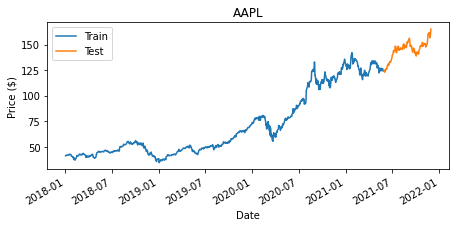

In [6]:
plt.figure(figsize=FIGSIZE)
train_df['Close'].plot(label='Train')
test_df['Close'].plot(label='Test')
plt.title(f'{TICKER}')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.legend();

if SAVE_FIGS:
    plt.savefig(f'../figures/train-test-{TICKER}.png', dpi=DPI, bbox_inches='tight', facecolor='White')

## Separate features and targets & scale features
Fit a standard scaler to the features of the train set. Then scale the features of the train and test set using this scaler. Also return the selected target variables for the train and test set.

In [7]:
X_train, X_test, y_train, y_test, scaler_object = processing.get_X_y(train_df, test_df, target_var_name='TARGET_return', do_scale=True)

# Build, train and test models

## Define models
Define the models that will be trained here. This is where you can add your own models to expand the analysis. Note that these models all have a `.fit(X_train, y_train)` method. Make sure any added modles conform to this convention.

In [8]:
models = {
    'Linear': Lasso(random_state=RANDOM_SEED),
    'Random Forest': RandomForestRegressor(random_state=RANDOM_SEED),
    'MLP': MLPRegressor(random_state=RANDOM_SEED),
    'Naive': Naive(target_type='return'),
}

## Train models
Train the models on the training data

In [9]:
for model_name in models:
    print(f'Training {model_name}...')
    models[model_name] = models[model_name].fit(X_train, y_train)
print('done.')

Training Linear...
Training Random Forest...
Training MLP...
Training Naive...
done.


## Test models
Using the selected models, produce forecasts on the test set and assess the forecast error. Note that these models all have a `.predict(X_test)` method. Make sure any added modles conform to this convention.

In [10]:
# produce forecasts and calculate errors
forecasts_dict = {}
errors_dict = {}

for model_name in models:
    print(f'Producing forecasts for {model_name}...')
    y_pred = pd.Series(data=models[model_name].predict(X_test), index=X_test.index)
    forecasts_dict[model_name] = y_pred
    errors_dict[model_name] = mean_squared_error(y_true=y_test, y_pred=y_pred)**0.5

forecasts_df = pd.DataFrame(forecasts_dict)
error_df = pd.DataFrame(data=pd.Series(errors_dict, name='RMSE')).sort_values(by='RMSE', ascending=True)
print('done.')


Producing forecasts for Linear...
Producing forecasts for Random Forest...
Producing forecasts for MLP...
Producing forecasts for Naive...
done.


In [11]:
error_df

,RMSE
Linear,0.012540
Naive,0.012729
Random Forest,0.017893
MLP,0.063610


In [12]:
forecasts_df.head()

,Linear,Random Forest,MLP,Naive
Date,,,,
2021-06-01,0.00152,0.001757,0.047101,0.0
2021-06-02,0.00152,0.001003,0.019353,0.0
2021-06-03,0.00152,-0.000366,0.036983,0.0
2021-06-04,0.00152,-0.001304,0.034834,0.0
2021-06-07,0.00152,-0.000686,0.032156,0.0


## Compare errors
Visually compare the forecast errors using a bar plot

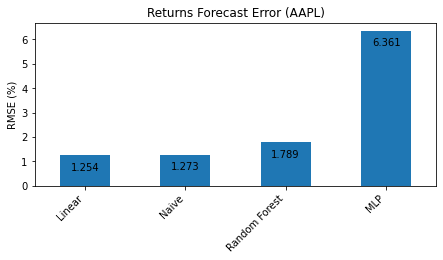

In [13]:
# plot RMSE for each ticker
ax = (error_df * 100.0).plot(kind='bar', title=f'Returns Forecast Error ({TICKER})', legend=False, figsize=(1.8*len(models),3))
ax.set_ylabel(error_df.columns[0])
# label bars
for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=3),
        (p.get_x()+p.get_width()/2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, -12),
        textcoords='offset points')
plt.xticks(rotation=45, ha='right')
plt.ylabel('RMSE (%)')

# save plot
if SAVE_FIGS:
    plt.savefig(f'../figures/errors-{TICKER}.png', dpi=DPI, bbox_inches='tight', facecolor='White')

## Assess forecasting strategies
Inspect the return forecasts to check for similarity to Naive forecast strategy. Note: the Naive strategy uses the current price as a forecast of the next day's price (it always forecasts 0.0 return)

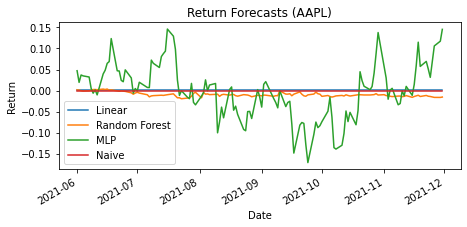

In [14]:
# plot returns forecast
forecasts_df.plot(figsize=FIGSIZE, title=f'Return Forecasts ({TICKER})')
plt.ylabel('Return')

# save plot
if SAVE_FIGS:
    plt.savefig(f'../figures/return-forecast-{TICKER}.png', dpi=DPI, bbox_inches='tight', facecolor='White')

### Getting price forecast from returns forecast
Getting the same returns forecast as a price forecast that is more intuitive (although it's harder to see the similarity to the Naive strategy)

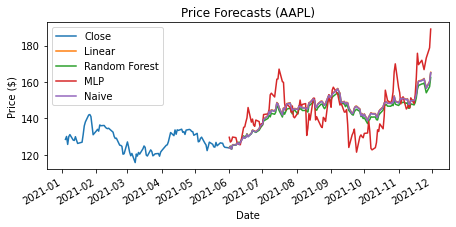

In [15]:
# get price forecast forecast
forecasts_price_df = (forecasts_df + 1.0) * test_df[['Close']].values
forecasts_price_df

# plot price forecast forecast
ax = df[['Close']]['2021':].plot(figsize=FIGSIZE, title=f'Price Forecasts ({TICKER})')
forecasts_price_df.plot(ax=ax)

plt.ylabel('Price ($)')

# save plot
if SAVE_FIGS:
    plt.savefig(f'../figures/price-forecast-{TICKER}.png', dpi=DPI, bbox_inches='tight', facecolor='White')